In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 916.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1639
             Open   High    Low  Close   Volume Ticker
Time                                                  
2017-06-02  10590  11040  10510  10950  5519180    SSI
2017-06-05  11000  11040  10740  10740  2811740    SSI
2017-06-06  10800  10910  10720  10870  2952940    SSI
2017-06-07  10950  11140  10930  10980  4110110    SSI
2017-06-08  11040  11210  10930  11060  3599060    SSI
2017-06-09  11120  11300  11080  11140  3427850    SSI


<Axes: xlabel='Time'>

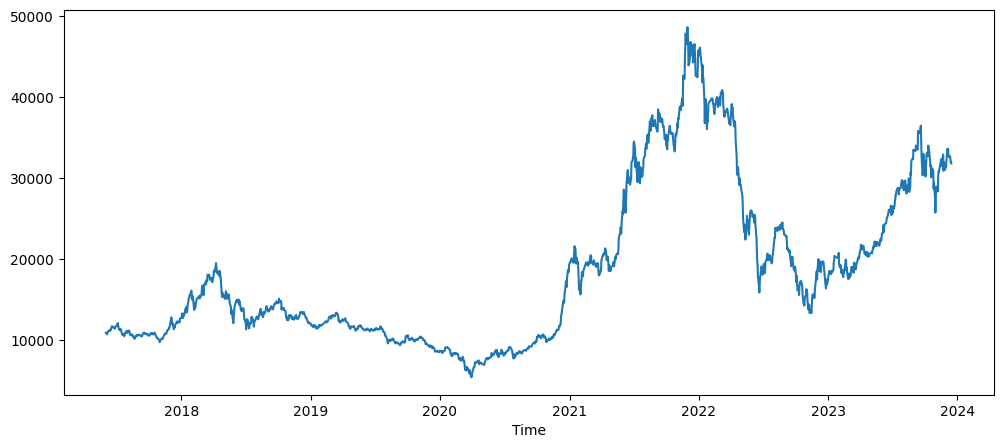

In [3]:
# Import data
SSI = stock_historical_data(symbol = "SSI", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(SSI['Close']))
print(pd.DataFrame(SSI.head(6)))
train_dates = SSI.index
plt.figure(figsize=(12, 5))
SSI["Close"].plot()

In [4]:
SSI = SSI.reset_index(drop = True)
df = SSI['Close']
df

0       10950
1       10740
2       10870
3       10980
4       11060
        ...  
1634    32700
1635    32600
1636    32000
1637    32000
1638    31800
Name: Close, Length: 1639, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7
0,62.890229,-35.232749,-557.734499,190.705087,1435.798915,-2052.008201,11905.581218
1,-85.419349,-86.542356,-570.893398,189.115856,1440.017131,-2051.752090,11905.474207
2,8.503355,-61.772972,-561.900346,187.578549,1443.093079,-2050.870528,11905.368863
3,25.385600,0.286147,-532.716447,186.132683,1445.005105,-2049.358188,11905.265100
4,3.993016,54.247781,-486.718993,184.792050,1445.733148,-2047.209918,11905.162916
...,...,...,...,...,...,...,...
1634,66.736713,-484.969589,133.940067,2463.252565,15090.338498,-15391.655924,30822.357671
1635,148.832301,-547.900933,-17.768444,2508.326388,15047.593101,-15359.997726,30820.915313
1636,-141.938880,-732.034364,-144.751931,2519.652080,15007.495104,-15327.853407,30819.431398
1637,108.714275,-875.432608,-218.111213,2492.042218,14970.106822,-15295.225464,30817.905970


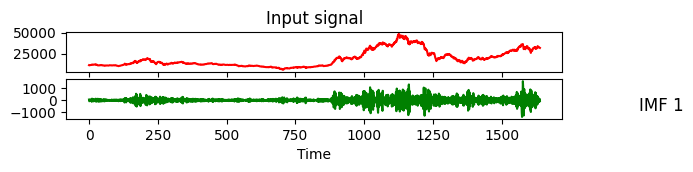

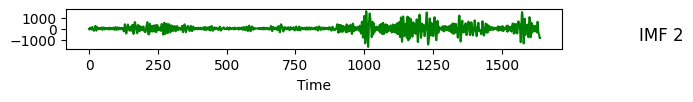

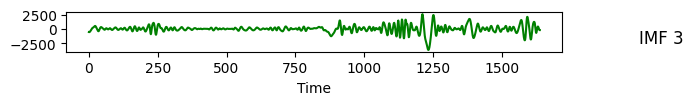

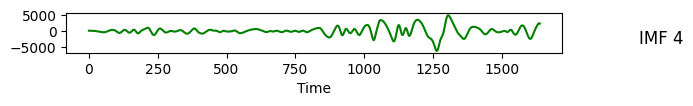

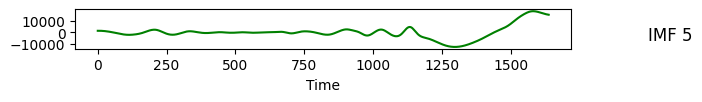

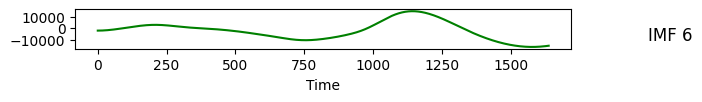

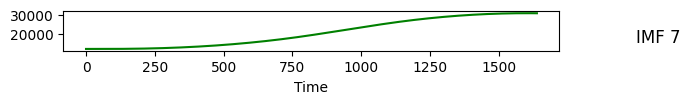

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1639, 1)
Residue: (1639, 1)


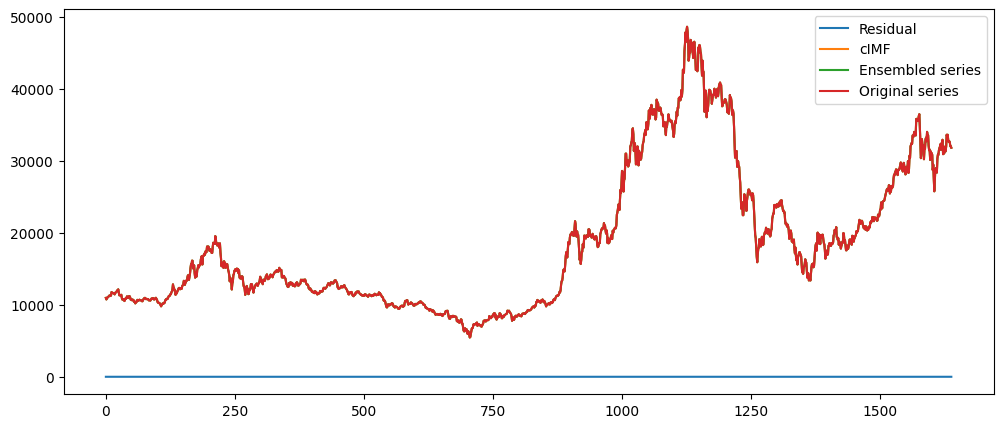

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [13]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[10950.],
       [10740.],
       [10870.],
       ...,
       [32000.],
       [32000.],
       [31800.]])

In [14]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1639, 1)
Train:  (1475, 1)
Test:  (164, 1)


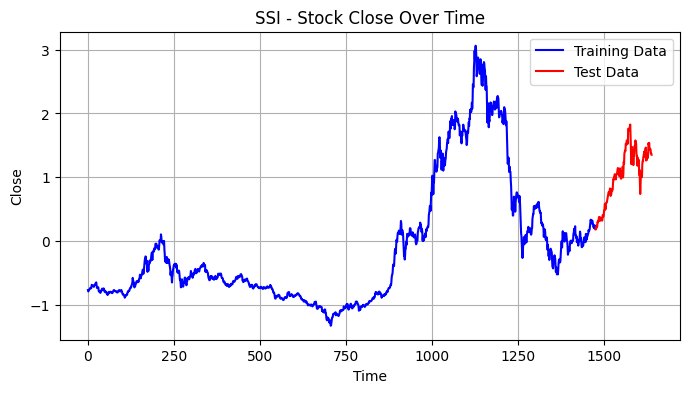

In [15]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.9*IMFscale.shape[0])
test_size = int(0.1*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('SSI - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1415, 60, 1)
Y train:  (1415, 1)


In [17]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (104, 60, 1)
Y test:  (104, 1)


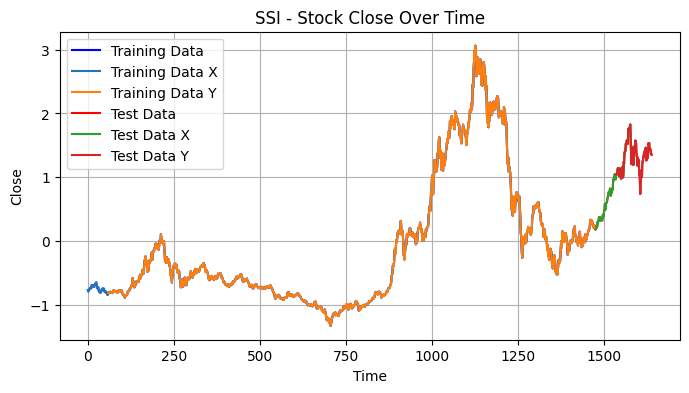

In [18]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('SSI - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
## 1. Train model
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=20, validation_split=0.2, verbose=1)

Epoch 1/50
57/57 [==============================] - 8s 63ms/step - loss: 73.9055 - val_loss: 113.8076
Epoch 2/50
57/57 [==============================] - 3s 51ms/step - loss: 46.2089 - val_loss: 116.0478
Epoch 3/50
57/57 [==============================] - 3s 56ms/step - loss: 39.1076 - val_loss: 113.7739
Epoch 4/50
57/57 [==============================] - 4s 73ms/step - loss: 33.2735 - val_loss: 106.0287
Epoch 5/50
57/57 [==============================] - 3s 51ms/step - loss: 30.9439 - val_loss: 111.8603
Epoch 6/50
57/57 [==============================] - 3s 52ms/step - loss: 30.5277 - val_loss: 109.0473
Epoch 7/50
57/57 [==============================] - 3s 51ms/step - loss: 30.9055 - val_loss: 117.6589
Epoch 8/50
57/57 [==============================] - 5s 80ms/step - loss: 29.0105 - val_loss: 120.2868
Epoch 9/50
57/57 [==============================] - 3s 51ms/step - loss: 28.6925 - val_loss: 113.3165
Epoch 10/50
57/57 [==============================] - 3s 55ms/step - loss: 29.0487 

In [21]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

4/4 [==============================] - 0s 14ms/step
[29962.434 29981.688 29996.91  30025.383 30090.658 30249.15  30477.338
 30671.719 30637.922 30565.297 30372.86  30311.266 30404.945 30419.969
 30309.785 30070.414 29831.756 29829.549 29826.633 29871.379 30159.475
 30151.324 30163.084 30555.357 30957.195 31666.652 32399.352 33052.156
 33492.414 34017.96  34389.24  34583.223 34806.113 34862.406 34857.516
 34749.277 35210.59  35726.234 36095.246 36273.    36384.95  36566.86
 36777.11  36471.887 35550.48  34161.645 33103.57  32842.355 32764.605
 32713.387 32791.96  32485.889 32492.936 32578.744 33002.88  33527.812
 33862.695 34380.45  34715.16  34884.855 34570.477 34007.215 33497.43
 32770.426 32403.332 32068.621 31937.455 31862.197 31387.111 31045.89
 30409.47  29476.46  28847.807 28743.584 28889.318 29182.428 29388.951
 29946.855 30673.014 31343.13  32014.678 32604.084 33065.36  33436.27
 33466.965 33565.95  33663.477 33804.94  33430.516 33229.547 32869.086
 32631.387 32526.146 32429.07

In [22]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

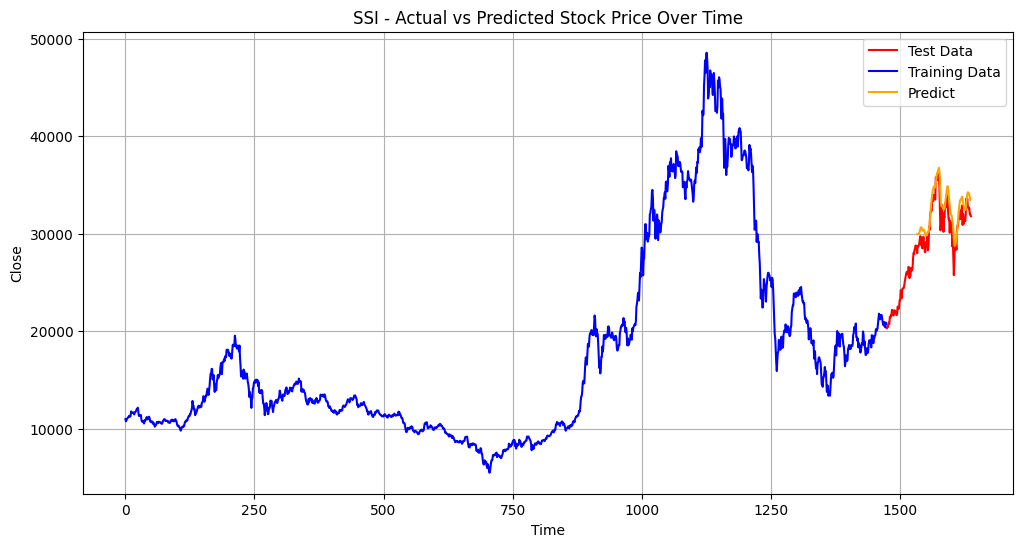

In [23]:
plt.figure(figsize=(12, 6))
n_future = 60

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('SSI - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 31ms/step
(165, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(166, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(167, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 36ms/step
(168, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(169, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(170, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(171, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(172, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(173, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(174, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 32ms/step
(175, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 37ms/step
(176, 1)
(60, 1)
(1, 60, 1)
1/1 [================

In [25]:
print(y_forecast)

[[33226.555]
 [33381.01 ]
 [33677.57 ]
 [34050.176]
 [34465.207]
 [34903.24 ]
 [35350.297]
 [35795.027]
 [36227.68 ]
 [36639.96 ]
 [37025.17 ]
 [37378.445]
 [37696.88 ]
 [37979.566]
 [38227.49 ]
 [38443.24 ]
 [38630.7  ]
 [38794.613]
 [38940.21 ]
 [39072.785]
 [39197.4  ]
 [39318.594]
 [39440.215]
 [39565.297]
 [39696.023]
 [39833.742]
 [39979.03 ]
 [40131.793]
 [40291.395]
 [40456.797]
 [40626.707]
 [40799.695]
 [40974.35 ]
 [41149.37 ]
 [41323.633]
 [41496.277]
 [41666.73 ]
 [41834.688]
 [42000.133]
 [42163.3  ]
 [42324.613]
 [42484.65 ]
 [42644.082]
 [42803.64 ]
 [42964.055]
 [43126.77 ]
 [43292.613]
 [43462.016]
 [43635.254]
 [43812.492]
 [43993.793]
 [44179.195]
 [44368.715]
 [44562.375]
 [44760.254]
 [44962.48 ]
 [45169.277]
 [45380.918]
 [45597.8  ]
 [45820.387]]


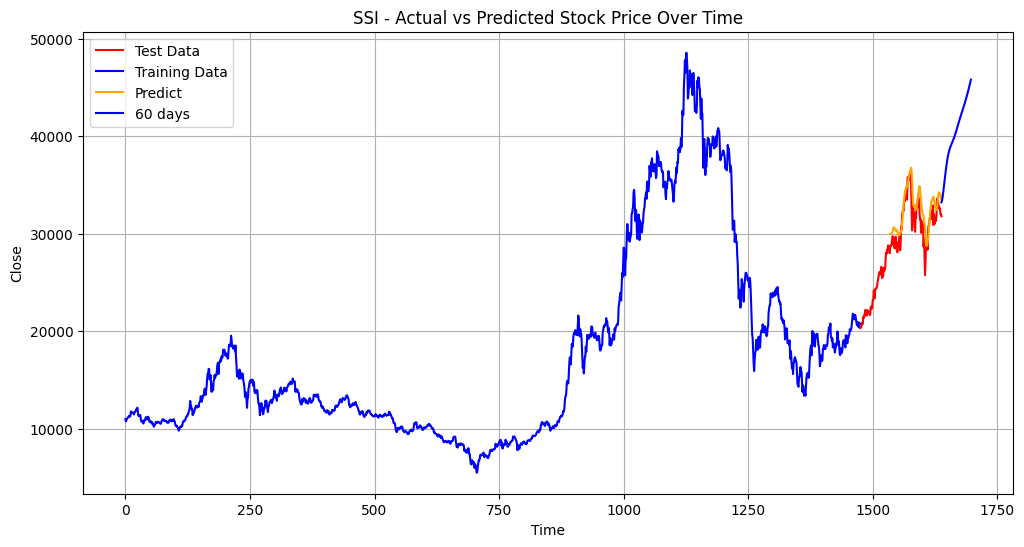

In [26]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size + 60, train_size + test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('SSI - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100

In [28]:
print("RSME: ", RSME(y_pred_future, test_back[-60:]))
print("MAE: ", MAE(y_pred_future, test_back[-60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[-60:]))

RSME:  2843.473376656092
MAE:  2273.9362611428287
MAPE:  7.432645642789939


In [29]:
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("MSLR: ", MSLE(y_pred_future, test_back[14:]))

MSLR:  0.031205990019247787
